## Imports

In [1]:
from datetime import datetime

import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from utils import load_and_filter_csv

## Setup

In [2]:
# Setup file names
datadir = '../data/'
sdis91_filepath = datadir + 'interventions-hebdo-2010-2017.csv'
grippe_filepath = datadir + 'incidence-RDD-3-syndromes-grippaux.csv'
diarrhee_filepath = datadir + 'incidence-RDD-6-syndrome-diarrhee-aigue.csv'
varicelle_filepath = datadir + 'incidence-RDD-7-varicelle.csv'
days_off_filepath = datadir + 'hollidays_and_days_off.csv'
wwo_filepath = datadir + 'wwo_hist.csv'

print('Import SDIS data')
sdis91_data = load_and_filter_csv(sdis91_filepath, None, separator=';')

# Filtering function to keep the location and the good date interval for ill CSVs
filter_rdd_files = lambda row: row[1]['geo_name'] == 'ILE-DE-FRANCE' and\
                               201001 <= row[1]['week'] <= 201752

print('Import flu data')
grippe_data = load_and_filter_csv(grippe_filepath, filter_rdd_files)

print('Import diarrhoea data')
diarrhee_data = load_and_filter_csv(diarrhee_filepath, filter_rdd_files)

print('Import chickenpox data')
varicelle_data = load_and_filter_csv(varicelle_filepath, filter_rdd_files)

rdd_datasets = {
    "grippe": grippe_data,
    "diarrhee": diarrhee_data,
    "varicelle": varicelle_data
}

print('Import days_off data')
days_off_data = load_and_filter_csv(days_off_filepath,
                                    lambda row:'2010-01-01' <= row[1]['date'] <= '2017-12-12')

print('Import weather data')
wwo_data = load_and_filter_csv(wwo_filepath, None)

print('Setup complete')

Import SDIS data
Import flu data
Import diarrhoea data
Import chickenpox data
Import days_off data
Import weather data
Setup complete


In [3]:
display(
    sdis91_data.head(),
    sdis91_data.tail(),
)

,ope_code_insee,nb_ope,ope_annee,ope_semaine,ope_categorie,ope_code_postal,ope_nom_commune
0,91001.0,0.0,2010.0,1.0,INCN,91150.0,ABBEVILLE LA RIVIERE
1,91016.0,0.0,2010.0,1.0,INCN,91670.0,ANGERVILLE
2,91017.0,0.0,2010.0,1.0,INCN,91470.0,ANGERVILLIERS
3,91021.0,0.0,2010.0,1.0,INCN,91290.0,ARPAJON
4,91022.0,0.0,2010.0,1.0,INCN,91690.0,ARRANCOURT


,ope_code_insee,nb_ope,ope_annee,ope_semaine,ope_categorie,ope_code_postal,ope_nom_commune
405036,91286.0,59.0,2017.0,52.0,SUAP,91350.0,GRIGNY
405037,91549.0,64.0,2017.0,52.0,SUAP,91700.0,STE GENEVIEVE DES BOIS
405038,91174.0,77.0,2017.0,52.0,SUAP,91100.0,CORBEIL ESSONNES
405039,91377.0,84.0,2017.0,52.0,SUAP,91300.0,MASSY
405040,91228.0,103.0,2017.0,52.0,SUAP,91000.0,EVRY


In [4]:
# sdis91_data cleanup
sdis91_data['yearweek'] = sdis91_data.ope_annee.astype(int).astype(str) + sdis91_data.ope_semaine.astype(int).map("{:02}".format)

# explanation :
# ope_annee.astype(int)
# we get rid of the .0 after the year then convert to string

# ope_semaine.apply('{:0>2}'.format)
# '1' -> '01' (explicitly converting to string)

# we convert both left and right operands to strings or
# else they are summed instead of concatenated

# sdis91_data['yearweek'] = sdis91_data['yearweek'].astype(float).astype(int) ##########
# when astype(int) is used directly, it causes the following error:
# invalid literal for int() with base 10 (...)

sdis91_data.drop('ope_nom_commune', axis=1, inplace=True)
sdis91_data.drop('ope_code_postal', axis=1, inplace=True)
sdis91_data.drop('ope_code_insee', axis=1, inplace=True)


# drop annee and semaine because we now have yearweek (ISO8601 Yearweek)
sdis91_data.drop('ope_annee', axis=1, inplace=True)
sdis91_data.drop('ope_semaine', axis=1, inplace=True)

# sdis91_data.rename(
#     columns={'ope_code_insee': 'insee_commune'},
#     inplace=True,
# )

# sdis91_data['insee_commune'] = sdis91_data['insee_commune'].astype(int)
sdis91_data['nb_ope'] = sdis91_data['nb_ope'].astype(int)


display(
    sdis91_data.head(),
    sdis91_data.tail(),
)




,nb_ope,ope_categorie,yearweek
0,0,INCN,201001
1,0,INCN,201001
2,0,INCN,201001
3,0,INCN,201001
4,0,INCN,201001


,nb_ope,ope_categorie,yearweek
405036,59,SUAP,201752
405037,64,SUAP,201752
405038,77,SUAP,201752
405039,84,SUAP,201752
405040,103,SUAP,201752


In [5]:
# group by on sdis91 dataset

sdis91_data = sdis91_data.groupby(['yearweek', 'ope_categorie']).nb_ope.sum().unstack().reset_index()

# get rid of index name, as it is by default "ope_categorie"
sdis91_data.columns.name = None

# add total_ope column
sdis91_data['ope_total'] = sdis91_data['ACCI'] + sdis91_data['AUTR'] + sdis91_data['INCN'] + sdis91_data['INCU'] + sdis91_data['SUAP']

# rename operation categories columns
# sdis91_data.rename(
#     columns={
#         'ACCI': 'ope_ACCI',
#         'AUTR': 'ope_AUTR',
#         'INCN': 'ope_INCN',
#         'INCU': 'ope_INCU',
#         'SUAP': 'ope_SUAP',
#     },
#     inplace=True,
# )

display(
    sdis91_data.head(10),
    sdis91_data.tail(10),
)

,yearweek,ACCI,AUTR,INCN,INCU,SUAP,ope_total
0,201001,81,232,0,129,1397,1839
1,201002,84,163,1,144,1383,1775
2,201003,74,107,0,123,1192,1496
3,201004,78,105,0,130,1316,1629
4,201005,84,111,0,117,1341,1653
5,201006,103,129,1,120,1350,1703
6,201007,84,106,0,145,1307,1642
7,201008,72,1086,0,133,1197,2488
8,201009,74,161,5,156,1095,1491
9,201010,58,124,11,152,1238,1583


,yearweek,ACCI,AUTR,INCN,INCU,SUAP,ope_total
406,201743,92,79,1,88,1411,1671
407,201744,84,58,2,148,1313,1605
408,201745,107,72,2,107,1500,1788
409,201746,96,73,1,104,1540,1814
410,201747,120,50,2,106,1622,1900
411,201748,139,48,3,88,1502,1780
412,201749,110,59,2,92,1645,1908
413,201750,145,195,0,75,1737,2152
414,201751,129,56,1,93,1632,1911
415,201752,118,98,1,140,1972,2329


In [6]:
for dataset_name, dataset in rdd_datasets.items():
    display(
        dataset_name,
        dataset.head(3),
        dataset.tail(3),
    )

'grippe'

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
0,201752,3,48723,38697,58749,402,319,485,11,ILE-DE-FRANCE
1,201751,3,49403,40654,58152,408,336,480,11,ILE-DE-FRANCE
2,201750,3,39953,32596,47310,330,269,391,11,ILE-DE-FRANCE


,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
414,201003,3,4816,1817,7815,41,15,67,11,ILE-DE-FRANCE
415,201002,3,9134,4877,13391,78,42,114,11,ILE-DE-FRANCE
416,201001,3,10207,5847,14567,87,50,124,11,ILE-DE-FRANCE


'diarrhee'

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
0,201752,6,14938,9638,20238,123,79,167,11,ILE-DE-FRANCE
1,201751,6,16218,11040,21396,134,91,177,11,ILE-DE-FRANCE
2,201750,6,20995,15775,26215,173,130,216,11,ILE-DE-FRANCE


,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
414,201003,6,60448,49467,71429,518,424,612,11,ILE-DE-FRANCE
415,201002,6,61576,48316,74836,527,413,641,11,ILE-DE-FRANCE
416,201001,6,42889,33449,52329,367,286,448,11,ILE-DE-FRANCE


'varicelle'

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
0,201752,7,368,0,920,3,0,8,11,ILE-DE-FRANCE
1,201751,7,799,0,1962,7,0,17,11,ILE-DE-FRANCE
2,201750,7,2228,476,3980,18,4,32,11,ILE-DE-FRANCE


,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
414,201003,7,1420,0,3082,12,0,26,11,ILE-DE-FRANCE
415,201002,7,3120,267,5973,27,3,51,11,ILE-DE-FRANCE
416,201001,7,3735,242,7228,32,2,62,11,ILE-DE-FRANCE


In [7]:
# rdd_datasets cleanup

for _, rdd_dataset in rdd_datasets.items():

    # always 11 and "ILE-DE-FRANCE"
    rdd_dataset.drop('geo_name', axis=1, inplace=True)
    rdd_dataset.drop('geo_insee', axis=1, inplace=True)

    # always 3, representing grippe, "Influenza-like illness"
    rdd_dataset.drop('indicator', axis=1, inplace=True)

    # drop these values for now
    rdd_dataset.drop('inc_low', axis=1, inplace=True)
    rdd_dataset.drop('inc_up', axis=1, inplace=True)
    rdd_dataset.drop('inc100', axis=1, inplace=True)
    rdd_dataset.drop('inc100_low', axis=1, inplace=True)
    rdd_dataset.drop('inc100_up', axis=1, inplace=True)

    rdd_dataset.rename(
        columns={'week': 'yearweek'},
        inplace=True,
    )

In [8]:
for dataset_name, dataset in rdd_datasets.items():
    display(
        dataset_name,
        dataset.head(3),
        dataset.tail(3),
    )

'grippe'

,yearweek,inc
0,201752,48723
1,201751,49403
2,201750,39953


,yearweek,inc
414,201003,4816
415,201002,9134
416,201001,10207


'diarrhee'

,yearweek,inc
0,201752,14938
1,201751,16218
2,201750,20995


,yearweek,inc
414,201003,60448
415,201002,61576
416,201001,42889


'varicelle'

,yearweek,inc
0,201752,368
1,201751,799
2,201750,2228


,yearweek,inc
414,201003,1420
415,201002,3120
416,201001,3735


In [9]:
display(
    days_off_data.head(),
    days_off_data.tail(),
)

,date,vacances_zone_a,vacances_zone_b,vacances_zone_c,nom_vacances
0,2010-01-01,True,True,True,Vacances de Noël
1,2010-01-02,True,True,True,Vacances de Noël
2,2010-01-03,True,True,True,Vacances de Noël
3,2010-02-06,False,True,False,Vacances d'hiver
4,2010-02-07,False,True,False,Vacances d'hiver


,date,vacances_zone_a,vacances_zone_b,vacances_zone_c,nom_vacances
1193,2017-11-01,True,True,True,Vacances de la Toussaint
1194,2017-11-02,True,True,True,Vacances de la Toussaint
1195,2017-11-03,True,True,True,Vacances de la Toussaint
1196,2017-11-04,True,True,True,Vacances de la Toussaint
1197,2017-11-05,True,True,True,Vacances de la Toussaint


In [10]:
# vacation zone for Ile-De-France : Zone C
days_off_data.drop('vacances_zone_a', axis=1, inplace=True)
days_off_data.drop('vacances_zone_b', axis=1, inplace=True)

# don't need the name
days_off_data.drop('nom_vacances', axis=1, inplace=True)

days_off_data['yearweek'] = days_off_data.apply(
    lambda x:
        # year
        str(datetime.strptime(x['date'], '%Y-%m-%d').year) +

        # plus week number (while adding leading 0 if needed)
        "{:02d}".format(datetime.strptime(x['date'], '%Y-%m-%d').isocalendar()[1]),
        axis=1
)

# date isn't needed anymore, as we now have yearweek
days_off_data.drop('date', axis=1, inplace=True)

days_off_data.rename(
    columns={'vacances_zone_c': 'has_vacation'},
    inplace=True,
)

# days_off_data does not contain a line per week, only a line where it is holiday in at
# least one of the three zones, so now we have some lines where the "has_vacation"
# column is false. It corresponds to when some other zone is in vacation, but not the zone C, we don't need it.
days_off_data.drop(days_off_data[days_off_data.has_vacation == False].index, inplace=True)

# 'not days_off_data.has_vacation' doesn't work (it is ambiguous), thus the use
# of == False

# replace "True" by 1
days_off_data['has_vacation'] = days_off_data['has_vacation'].astype(int)

display(
    days_off_data.head(),
    days_off_data.tail(),
)

,has_vacation,yearweek
0,1,201053
1,1,201053
2,1,201053
17,1,201007
18,1,201007


,has_vacation,yearweek
1193,1,201744
1194,1,201744
1195,1,201744
1196,1,201744
1197,1,201744


In [11]:
display(
    wwo_data.head(),
    wwo_data.tail(),
)

,week,temperature_max,temperature_min,temperature_average,total_snow_cm,precipitation_mm,city
0,201752,13.0,0.0,6.71,0.0,7.1,Ondreville-Sur-Essonne
1,201751,9.0,2.0,6.57,0.0,3.6,Ondreville-Sur-Essonne
2,201750,9.0,1.0,4.86,0.0,6.9,Ondreville-Sur-Essonne
3,201749,10.0,0.0,4.57,0.1,1.9,Ondreville-Sur-Essonne
4,201748,9.0,-1.0,3.00,0.0,8.5,Ondreville-Sur-Essonne


,week,temperature_max,temperature_min,temperature_average,total_snow_cm,precipitation_mm,city
412,201005,9.0,-2.0,4.29,0.2,10.5,Ondreville-Sur-Essonne
413,201004,5.0,-5.0,0.43,0.2,0.7,Ondreville-Sur-Essonne
414,201003,7.0,-1.0,2.29,0.0,1.9,Ondreville-Sur-Essonne
415,201002,8.0,-5.0,0.71,1.5,2.5,Ondreville-Sur-Essonne
416,201001,-0.0,-10.0,-4.43,2.6,3.2,Ondreville-Sur-Essonne


In [12]:
# cleanup wwo_data

# city is always "Ondreville-Sur-Essonne"
wwo_data.drop('city', axis=1, inplace=True)

wwo_data.rename(
    columns={'week': 'yearweek'},
    inplace=True,
)

display(
    wwo_data.head(),
    wwo_data.tail(),
)

,yearweek,temperature_max,temperature_min,temperature_average,total_snow_cm,precipitation_mm
0,201752,13.0,0.0,6.71,0.0,7.1
1,201751,9.0,2.0,6.57,0.0,3.6
2,201750,9.0,1.0,4.86,0.0,6.9
3,201749,10.0,0.0,4.57,0.1,1.9
4,201748,9.0,-1.0,3.00,0.0,8.5


,yearweek,temperature_max,temperature_min,temperature_average,total_snow_cm,precipitation_mm
412,201005,9.0,-2.0,4.29,0.2,10.5
413,201004,5.0,-5.0,0.43,0.2,0.7
414,201003,7.0,-1.0,2.29,0.0,1.9
415,201002,8.0,-5.0,0.71,1.5,2.5
416,201001,-0.0,-10.0,-4.43,2.6,3.2


In [13]:
# aggregate everything

# sdis91_data

# grippe_data
# diarrhee_data,
# varicelle_data

# days_off_data
# wwo_data

diseases_data = grippe_data.merge(
    diarrhee_data, on='yearweek', how='outer'
).merge(
    varicelle_data, on='yearweek', how='outer'
)

diseases_data.rename(
    columns={
        'inc_x': 'inc_grippe',
        'inc_y': 'inc_diarrhee',
        'inc': 'inc_varicelle',
    },
    inplace=True,
)


# set same type for every yearweek columns so it can be merged easier
sdis91_data['yearweek'] = sdis91_data['yearweek'].astype('int64')
diseases_data['yearweek'] = diseases_data['yearweek'].astype('int64')
wwo_data['yearweek'] = wwo_data['yearweek'].astype('int64')
days_off_data['yearweek'] = days_off_data['yearweek'].astype('int64')

# merge all datasets
merged_data = sdis91_data.merge(
    diseases_data, on='yearweek', how='outer'
).merge(
    days_off_data, on='yearweek', how='outer'
).merge(
    wwo_data, on='yearweek', how='outer'
)


# replace NaN by 0 ("false") in has_vacation columns
merged_data['has_vacation'].fillna(0, inplace=True)

# drop all the columns where any value is NaN
merged_data.dropna(axis=0, how='any', inplace=True)

display(
    merged_data.head(15),
    merged_data.tail(15),
)

,yearweek,ACCI,AUTR,INCN,INCU,SUAP,ope_total,inc_grippe,inc_diarrhee,inc_varicelle,has_vacation,temperature_max,temperature_min,temperature_average,total_snow_cm,precipitation_mm
0,201001,81.0,232.0,0.0,129.0,1397.0,1839.0,10207,42889,3735,0.0,-0.0,-10.0,-4.43,2.6,3.2
1,201002,84.0,163.0,1.0,144.0,1383.0,1775.0,9134,61576,3120,0.0,8.0,-5.0,0.71,1.5,2.5
2,201003,74.0,107.0,0.0,123.0,1192.0,1496.0,4816,60448,1420,0.0,7.0,-1.0,2.29,0.0,1.9
3,201004,78.0,105.0,0.0,130.0,1316.0,1629.0,4348,61601,1284,0.0,5.0,-5.0,0.43,0.2,0.7
4,201005,84.0,111.0,0.0,117.0,1341.0,1653.0,2888,47258,6835,0.0,9.0,-2.0,4.29,0.2,10.5
5,201006,103.0,129.0,1.0,120.0,1350.0,1703.0,1695,44471,3463,0.0,3.0,-7.0,-2.57,0.7,1.8
6,201007,84.0,106.0,0.0,145.0,1307.0,1642.0,2646,39867,7090,1.0,8.0,-6.0,1.00,0.2,3.1
7,201007,84.0,106.0,0.0,145.0,1307.0,1642.0,2646,39867,7090,1.0,8.0,-6.0,1.00,0.2,3.1
8,201008,72.0,1086.0,0.0,133.0,1197.0,2488.0,3000,29301,5632,1.0,12.0,4.0,8.14,0.0,9.4
9,201008,72.0,1086.0,0.0,133.0,1197.0,2488.0,3000,29301,5632,1.0,12.0,4.0,8.14,0.0,9.4


,yearweek,ACCI,AUTR,INCN,INCU,SUAP,ope_total,inc_grippe,inc_diarrhee,inc_varicelle,has_vacation,temperature_max,temperature_min,temperature_average,total_snow_cm,precipitation_mm
1193,201744,84.0,58.0,2.0,148.0,1313.0,1605.0,200,5887,96,1.0,16.0,5.0,10.00,0.0,1.0
1194,201744,84.0,58.0,2.0,148.0,1313.0,1605.0,200,5887,96,1.0,16.0,5.0,10.00,0.0,1.0
1195,201744,84.0,58.0,2.0,148.0,1313.0,1605.0,200,5887,96,1.0,16.0,5.0,10.00,0.0,1.0
1196,201744,84.0,58.0,2.0,148.0,1313.0,1605.0,200,5887,96,1.0,16.0,5.0,10.00,0.0,1.0
1197,201744,84.0,58.0,2.0,148.0,1313.0,1605.0,200,5887,96,1.0,16.0,5.0,10.00,0.0,1.0
1198,201744,84.0,58.0,2.0,148.0,1313.0,1605.0,200,5887,96,1.0,16.0,5.0,10.00,0.0,1.0
1199,201744,84.0,58.0,2.0,148.0,1313.0,1605.0,200,5887,96,1.0,16.0,5.0,10.00,0.0,1.0
1200,201745,107.0,72.0,2.0,107.0,1500.0,1788.0,3612,11987,160,0.0,13.0,3.0,8.00,0.0,5.1
1201,201746,96.0,73.0,1.0,104.0,1540.0,1814.0,4854,15145,684,0.0,10.0,3.0,6.57,0.0,0.3
1202,201747,120.0,50.0,2.0,106.0,1622.0,1900.0,3561,15815,894,0.0,15.0,2.0,8.43,0.0,1.9


In [14]:
# Export to CSV
merged_data.to_csv('merged_data.csv', sep='\t', encoding='utf-8', header='true')

# -----------
# Visualization

<AxesSubplot:xlabel='yearweek'>

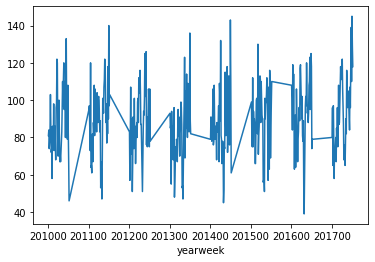

In [15]:
merged_data.set_index(['yearweek'], inplace=True)
merged_data.ACCI.plot()

## Random Forest Regressor on SUAP

In [16]:
model_random_forest = StandardScaler()

# All columns except yearweek and all interventions numbers
features_suap_random_forest = merged_data.columns[7:]
to_predict_suap_random_forest = 'SUAP'

X_suap_random_forest = merged_data[features_suap_random_forest]
y_suap_random_forest = merged_data[to_predict_suap_random_forest]

X_train_suap_random_forest, X_test_suap_random_forest, y_train_suap_random_forest, y_test_suap_random_forest = train_test_split(X_suap_random_forest, y_suap_random_forest, test_size=0.25)

X_train_suap_random_forest = model_random_forest.fit_transform(X_train_suap_random_forest)
X_test_suap_random_forest = model_random_forest.transform(X_test_suap_random_forest)

suap_random_forest_model = RandomForestRegressor(random_state=1)
suap_random_forest_model.fit(X_train_suap_random_forest, y_train_suap_random_forest)
y_predicted_suap_random_forest = suap_random_forest_model.predict(X_test_suap_random_forest)

mean_absolute_error(y_test_suap_random_forest, y_predicted_suap_random_forest)

22.937541528239205